In [213]:
# Cell 1: Import Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np # Added for handling inf/NaN in derived stats

print("Libraries imported successfully!")


Libraries imported successfully!


In [214]:
# Cell 2: Load and Concatenate Raw Data

# Directory where all ATP match CSVs are saved
data_path = '../tennis_atp/'  # Update if your path is different

# List of years you want to include
years = list(range(2010, 2025))

# Load and concatenate all relevant files
dfs = []
for year in years:
    file = os.path.join(data_path, f'atp_matches_{year}.csv')
    if os.path.exists(file):
        # Load CSV without 'format' or 'errors' arguments for read_csv (for older Pandas compatibility)
        df_year = pd.read_csv(file)
        dfs.append(df_year)
    else:
        print(f"Warning: File not found for year {year} at {file}")

# Combine all years into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Convert 'tourney_date' to datetime objects AFTER concatenation
# Specify the format here, as 'format' and 'errors' are valid for pd.to_datetime
df_all['tourney_date'] = pd.to_datetime(df_all['tourney_date'], format='%Y%m%d', errors='coerce')

# Sort by date and match_num to ensure chronological order for rolling calculations
df_all = df_all.sort_values(by=['tourney_date', 'match_num']).reset_index(drop=True)

print(f"Loaded {len(df_all)} total ATP matches from {years[0]} to {years[-1]}")
print("First 5 rows of combined data (with tourney_date as datetime):")
display(df_all.head())
print("\nData types after parsing date:")
display(df_all.info())
print(f"NaN count in df_all (before any processing): \n{df_all.isnull().sum().loc[lambda x : x > 0]}")

Loaded 42571 total ATP matches from 2010 to 2024
First 5 rows of combined data (with tourney_date as datetime):


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,2010-01-03,1,104053,1.0,NaN,...,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,2010-01-03,2,104958,NaN,WC,...,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,2010-01-03,3,104755,NaN,NaN,...,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,2010-01-03,4,105051,NaN,Q,...,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,2010-01-03,5,104607,4.0,NaN,...,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0



Data types after parsing date:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42571 entries, 0 to 42570
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_id          42571 non-null  object        
 1   tourney_name        42571 non-null  object        
 2   surface             42518 non-null  object        
 3   draw_size           42571 non-null  int64         
 4   tourney_level       42571 non-null  object        
 5   tourney_date        42571 non-null  datetime64[ns]
 6   match_num           42571 non-null  int64         
 7   winner_id           42571 non-null  int64         
 8   winner_seed         18166 non-null  float64       
 9   winner_entry        5668 non-null   object        
 10  winner_name         42571 non-null  object        
 11  winner_hand         42571 non-null  object        
 12  winner_ht           42080 non-null  float64       
 13  winner_ioc    

None

NaN count in df_all (before any processing): 
surface                  53
winner_seed           24405
winner_entry          36903
winner_ht               491
winner_age                3
loser_seed            32329
loser_entry           33418
loser_hand                4
loser_ht               1100
loser_age                 3
minutes                4383
w_ace                  2742
w_df                   2742
w_svpt                 2742
w_1stIn                2742
w_1stWon               2742
w_2ndWon               2742
w_SvGms                2742
w_bpSaved              2742
w_bpFaced              2742
l_ace                  2742
l_df                   2742
l_svpt                 2742
l_1stIn                2742
l_1stWon               2742
l_2ndWon               2742
l_SvGms                2742
l_bpSaved              2742
l_bpFaced              2742
winner_rank             262
winner_rank_points      262
loser_rank              671
loser_rank_points       671
dtype: int64


In [215]:
# Cell 3: Create Player-Centric Records for Rolling Statistics Calculation

# Ensure df_all has 'surface' column if it's not already present after initial loading
# For example, if you load from multiple CSVs, ensure 'surface' is read and present in df_all.

# Define stats columns we'll want to average for players
# These are the raw match stats that we want to track per player
player_stats_cols_raw = [
    'winner_age', 'winner_ht', 'winner_rank', 'winner_rank_points',
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
    'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'loser_age', 'loser_ht', 'loser_rank', 'loser_rank_points',
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
    'l_SvGms', 'l_bpSaved', 'l_bpFaced'
]

# Create records for the winner
# Use 'match_num' instead of 'match_id'
df_winners = df_all[['tourney_date', 'surface', 'match_num', 'winner_id', 'winner_name', 'loser_id', 'loser_name', 'score', 'best_of', 'round', 'minutes']].copy() # CHANGED 'match_id' to 'match_num'
df_winners = df_winners.rename(columns={'winner_id': 'player_id', 'winner_name': 'player_name',
                                        'loser_id': 'opponent_id', 'loser_name': 'opponent_name'})
df_winners['is_winner'] = 1 # Mark as winner

# Add winner's match stats and opponent's stats to winner's row
for col in player_stats_cols_raw:
    if col.startswith('w_'):
        df_winners[col.replace('w_', 'player_')] = df_all[col]
    elif col.startswith('winner_'):
        df_winners[col.replace('winner_', 'player_')] = df_all[col]
    elif col.startswith('l_'):
        df_winners[col.replace('l_', 'opponent_')] = df_all[col]
    elif col.startswith('loser_'):
        df_winners[col.replace('loser_', 'opponent_')] = df_all[col]

# Create records for the loser
# Use 'match_num' instead of 'match_id'
df_losers = df_all[['tourney_date', 'surface', 'match_num', 'loser_id', 'loser_name', 'winner_id', 'winner_name', 'score', 'best_of', 'round', 'minutes']].copy() # CHANGED 'match_id' to 'match_num'
df_losers = df_losers.rename(columns={'loser_id': 'player_id', 'loser_name': 'player_name',
                                      'winner_id': 'opponent_id', 'winner_name': 'opponent_name'})
df_losers['is_winner'] = 0 # Mark as loser

# Add loser's match stats and opponent's stats to loser's row
for col in player_stats_cols_raw:
    if col.startswith('l_'):
        df_losers[col.replace('l_', 'player_')] = df_all[col]
    elif col.startswith('loser_'):
        df_losers[col.replace('loser_', 'player_')] = df_all[col]
    elif col.startswith('w_'):
        df_losers[col.replace('w_', 'opponent_')] = df_all[col]
    elif col.startswith('winner_'):
        df_losers[col.replace('winner_', 'opponent_')] = df_all[col]

# Combine player records
player_df = pd.concat([df_winners, df_losers], ignore_index=True)
player_df['tourney_date'] = pd.to_datetime(player_df['tourney_date'], format='%Y%m%d')
player_df = player_df.sort_values(by=['player_id', 'tourney_date']).reset_index(drop=True)


# --- NEW ADDITIONS FOR DERIVED STATS (keep this as previously discussed) ---
# Calculate derived features for each match (before rolling averages)
player_df['1st_serve_in_pct'] = player_df['player_1stIn'] / player_df['player_svpt']
player_df['1st_serve_win_pct'] = player_df['player_1stWon'] / player_df['player_1stIn']
player_df['2nd_serve_win_pct'] = player_df['player_2ndWon'] / (player_df['player_svpt'] - player_df['player_1stIn'])
player_df['total_pts_won_on_serve_pct'] = (player_df['player_1stWon'] + player_df['player_2ndWon']) / player_df['player_svpt']

player_df['break_point_save_pct'] = player_df['player_bpSaved'] / player_df['player_bpFaced']
player_df['break_points_converted'] = player_df['opponent_bpFaced'] - player_df['opponent_bpSaved']
player_df['break_pct'] = player_df['break_points_converted'] / player_df['opponent_svpt'] # Assuming opponent_svpt is available


# Handle division by zero or NaN results from derived stats
for col in ['1st_serve_in_pct', '1st_serve_win_pct', '2nd_serve_win_pct',
            'break_point_save_pct', 'total_pts_won_on_serve_pct', 'break_pct']:
    player_df[col] = player_df[col].replace([np.inf, -np.inf], np.nan)
    player_df[col] = player_df[col].fillna(0) # or appropriate imputation strategy


print(f"Created {len(player_df)} player-centric records.")
print("First 5 rows of player_df (with new derived stats):")
display(player_df.head())
print(f"NaN count in player_df: \n{player_df.isnull().sum().loc[lambda x : x > 0]}")

Created 85142 player-centric records.
First 5 rows of player_df (with new derived stats):


,tourney_date,surface,match_num,player_id,player_name,opponent_id,opponent_name,score,best_of,round,...,opponent_SvGms,opponent_bpSaved,opponent_bpFaced,1st_serve_in_pct,1st_serve_win_pct,2nd_serve_win_pct,total_pts_won_on_serve_pct,break_point_save_pct,break_points_converted,break_pct
0,2013-07-15,Clay,6,100644,Alexander Zverev,105138,Roberto Bautista Agut,6-3 6-2,3,R64,...,9.0,6.0,9.0,0.358974,0.500000,0.240000,0.333333,0.250000,3.0,0.053571
1,2014-04-28,Clay,4,100644,Alexander Zverev,103781,Jurgen Melzer,6-1 6-2,3,R32,...,8.0,6.0,7.0,0.454545,0.450000,0.333333,0.386364,0.285714,1.0,0.021277
2,2014-07-07,Clay,8,100644,Alexander Zverev,104586,Lukas Rosol,7-6(7) 7-6(9),3,R32,...,12.0,1.0,3.0,0.580645,0.648148,0.615385,0.634409,0.500000,2.0,0.023256
3,2014-07-14,Clay,8,100644,Alexander Zverev,104898,Robin Haase,6-0 6-2,3,R64,...,7.0,4.0,9.0,0.568182,0.680000,0.789474,0.727273,1.000000,5.0,0.096154
4,2014-07-14,Clay,24,100644,Alexander Zverev,104022,Mikhail Youzhny,7-5 7-5,3,R32,...,12.0,7.0,11.0,0.467532,0.694444,0.560976,0.623377,0.600000,4.0,0.046512


NaN count in player_df: 
surface                    106
minutes                   8766
player_age                   6
player_ht                 1591
player_rank                933
player_rank_points         933
player_ace                5484
player_df                 5484
player_svpt               5484
player_1stIn              5484
player_1stWon             5484
player_2ndWon             5484
player_SvGms              5484
player_bpSaved            5484
player_bpFaced            5484
opponent_age                 6
opponent_ht               1591
opponent_rank              933
opponent_rank_points       933
opponent_ace              5484
opponent_df               5484
opponent_svpt             5484
opponent_1stIn            5484
opponent_1stWon           5484
opponent_2ndWon           5484
opponent_SvGms            5484
opponent_bpSaved          5484
opponent_bpFaced          5484
break_points_converted    5484
dtype: int64


In [216]:
# Cell 4: Calculate Rolling Averages for each player (General, Surface-Specific, and H2H)

# Define your rolling window (must be consistent with the configuration in tennis_predictor.py)
ROLLING_WINDOW = 10
ROLLING_DERIVED_COLS = [
    '1st_serve_in_pct', '1st_serve_win_pct', '2nd_serve_win_pct',
    'break_point_save_pct', 'total_pts_won_on_serve_pct', 'break_pct'
]

# Ensure player_df is sorted by player_id and tourney_date for correct general rolling calculations
player_df = player_df.sort_values(by=['player_id', 'tourney_date']).reset_index(drop=True)

# List of columns to calculate general and surface-specific rolling averages for
cols_for_rolling = [
    'is_winner', '1st_serve_in_pct', '1st_serve_win_pct',
    '2nd_serve_win_pct', 'break_point_save_pct',
    'total_pts_won_on_serve_pct', 'break_pct'
]

# --- NEW ADDITION: Shift 'current' player attributes to become 'previous' attributes ---
# These are the attributes that are constant per player for a given match, but we need
# their values from *before* the current match for predictive features.
# Shift by 1 to get the value from the previous match played by the same player.
for attr in ['player_rank', 'player_rank_points', 'player_age', 'player_ht']:
    player_df[f'{attr.replace("player_", "player_prev_")}'] = \
        player_df.groupby('player_id')[attr].shift(1)

# --- 1. General Rolling Averages (Existing functionality) ---
print(f"Calculating general rolling averages over last {ROLLING_WINDOW} matches...")
for col in cols_for_rolling:
    # Use .shift(1) to get stats *before* the current match (avoid data leakage)
    player_df[f'player_avg_{col}_last{ROLLING_WINDOW}'] = player_df.groupby('player_id')[col].transform(
        lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean().shift(1)
    )

# --- 2. NEW: Surface-Specific Rolling Averages ---
print(f"Calculating surface-specific rolling averages over last {ROLLING_WINDOW} matches on that surface...")
for col in cols_for_rolling:
    # Calculate rolling averages PER PLAYER AND PER SURFACE
    player_df[f'player_avg_{col}_on_surface_last{ROLLING_WINDOW}'] = player_df.groupby(['player_id', 'surface'])[col].transform(
        lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean().shift(1)
    )

# --- 3. NEW: Head-to-Head (H2H) Statistics ---
# H2H requires knowing wins/matches vs. a specific opponent BEFORE a match
# Sort by player_id, opponent_id, and tourney_date to ensure correct H2H calculation
# This sort is crucial for the H2H rolling context.
player_df = player_df.sort_values(by=['player_id', 'opponent_id', 'tourney_date']).reset_index(drop=True)

print("Calculating Head-to-Head (H2H) statistics...")

# Player's historical wins against THIS specific opponent
player_df['h2h_wins_vs_opponent'] = player_df.groupby(['player_id', 'opponent_id'])['is_winner'].transform(
    lambda x: x.rolling(window=1000, min_periods=1).sum().shift(1)
).fillna(0) # Fill NaN with 0 for players who haven't played this opponent before

# Total historical matches played against THIS specific opponent
player_df['h2h_matches_vs_opponent'] = player_df.groupby(['player_id', 'opponent_id'])['match_num'].transform( # Use 'match_num' here
    lambda x: x.rolling(window=1000, min_periods=1).count().shift(1)
).fillna(0) # Fill NaN with 0

# H2H win percentage (handle division by zero if no prior matches)
player_df['h2h_win_pct_vs_opponent'] = player_df['h2h_wins_vs_opponent'] / player_df['h2h_matches_vs_opponent']
player_df['h2h_win_pct_vs_opponent'] = player_df['h2h_win_pct_vs_opponent'].replace([np.inf, -np.inf], np.nan).fillna(0.5)


# --- Important: Save the updated player_df after all these calculations ---
import joblib
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
processed_data_dir = os.path.join(project_root, 'data', 'processed')
os.makedirs(processed_data_dir, exist_ok=True)
player_df_filename = os.path.join(processed_data_dir, 'player_df_historical.joblib')

joblib.dump(player_df, player_df_filename)
print(f"Updated pre-processed player_df saved successfully to {player_df_filename}")

print("\nFinished calculating all rolling averages and H2H stats.")
print("Sample of player_df with new columns (last 5 rows to see latest stats):")
display(player_df.tail())
print(f"NaN count in player_df (after all rolling calculations): \n{player_df.isnull().sum().loc[lambda x : x > 0]}")

Calculating general rolling averages over last 10 matches...
Calculating surface-specific rolling averages over last 10 matches on that surface...
Calculating Head-to-Head (H2H) statistics...
Updated pre-processed player_df saved successfully to /Users/nikhilvankayala/TennisForcaster/data/processed/player_df_historical.joblib

Finished calculating all rolling averages and H2H stats.
Sample of player_df with new columns (last 5 rows to see latest stats):


,tourney_date,surface,match_num,player_id,player_name,opponent_id,opponent_name,score,best_of,round,...,player_avg_is_winner_on_surface_last10,player_avg_1st_serve_in_pct_on_surface_last10,player_avg_1st_serve_win_pct_on_surface_last10,player_avg_2nd_serve_win_pct_on_surface_last10,player_avg_break_point_save_pct_on_surface_last10,player_avg_total_pts_won_on_serve_pct_on_surface_last10,player_avg_break_pct_on_surface_last10,h2h_wins_vs_opponent,h2h_matches_vs_opponent,h2h_win_pct_vs_opponent
85137,2024-02-03,Hard,4,212721,Benedict Badza,212722,Kwok Shun Dasson Chan,6-7(5) 6-4 [6-10],3,RR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.5
85138,2024-02-03,Hard,4,212722,Kwok Shun Dasson Chan,212721,Benedict Badza,6-7(5) 6-4 [6-10],3,RR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.5
85139,2024-08-26,Hard,129,212733,Matthew Forbes,126128,Roman Safiullin,6-4 7-6(2) 6-2,5,R128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.5
85140,2024-09-14,Hard,2,212866,Marcos Lee Chan Baratau,209409,Coleman Wong,6-3 3-6 6-1,3,RR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.5
85141,2024-09-14,Hard,1,212970,Jack Cheng,200748,Andres Andrade,6-1 6-1,3,RR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.5


NaN count in player_df (after all rolling calculations): 
surface                                                     106
minutes                                                    8766
player_age                                                    6
player_ht                                                  1591
player_rank                                                 933
player_rank_points                                          933
player_ace                                                 5484
player_df                                                  5484
player_svpt                                                5484
player_1stIn                                               5484
player_1stWon                                              5484
player_2ndWon                                              5484
player_SvGms                                               5484
player_bpSaved                                             5484
player_bpFaced                                

In [217]:
# Cell 5: Filter for Wimbledon and Merge Rolling Stats Back to Match Data

# Filter only Wimbledon matches from the original df_all
df_wimbledon = df_all[df_all['tourney_name'] == 'Wimbledon'].copy()

# Ensure unique match identifier - using tourney_date and match_num as match_id
df_wimbledon['match_id'] = df_wimbledon['tourney_date'].astype(str) + '_' + df_wimbledon['match_num'].astype(str)

# Select relevant match columns for merging
match_df = df_wimbledon[['match_id', 'tourney_date', 'winner_id', 'loser_id',
                         'winner_name', 'loser_name', 'tourney_name', 'surface', 'round']].copy()

print(f"Matches after initial Wimbledon filter: {len(df_wimbledon)}")

# Define columns to merge from player_df for general and surface-specific stats
# These are the player-centric columns that need to be merged for both winner and loser.
cols_to_merge_general_and_surface = [
    'player_prev_rank', 'player_prev_rank_points', 'player_prev_age', 'player_prev_ht'
] + [f'player_avg_{col_base}_last{ROLLING_WINDOW}' for col_base in ROLLING_DERIVED_COLS] + \
  [f'player_avg_is_winner_last{ROLLING_WINDOW}'] + \
  [f'player_avg_{col_base}_on_surface_last{ROLLING_WINDOW}' for col_base in ROLLING_DERIVED_COLS] + \
  [f'player_avg_is_winner_on_surface_last{ROLLING_WINDOW}']

# --- Merge winner's pre-match general & surface-specific stats ---
print("Merging winner's general and surface-specific pre-match stats...")
match_df = pd.merge(match_df, player_df[[
    'tourney_date', 'player_id' # Merge keys
] + cols_to_merge_general_and_surface], # Columns to bring over
    left_on=['tourney_date', 'winner_id'],
    right_on=['tourney_date', 'player_id'],
    how='left',
    suffixes=('_match', '_player') # Add suffixes to avoid column name conflicts if any
)
# Rename merged columns to reflect 'winner' and drop temporary 'player_id'
match_df = match_df.rename(columns={col: f'winner_{col.replace("player_", "")}' for col in cols_to_merge_general_and_surface})
match_df = match_df.drop(columns=['player_id']) # Drop the temporary player_id used in merge


# --- Merge loser's pre-match general & surface-specific stats ---
print("Merging loser's general and surface-specific pre-match stats...")
match_df = pd.merge(match_df, player_df[[
    'tourney_date', 'player_id' # Merge keys
] + cols_to_merge_general_and_surface], # Columns to bring over
    left_on=['tourney_date', 'loser_id'],
    right_on=['tourney_date', 'player_id'],
    how='left',
    suffixes=('_match', '_player')
)
# Rename merged columns to reflect 'loser' and drop temporary 'player_id'
match_df = match_df.rename(columns={col: f'loser_{col.replace("player_", "")}' for col in cols_to_merge_general_and_surface})
match_df = match_df.drop(columns=['player_id']) # Drop the temporary player_id used in merge


# --- NEW: Merge Head-to-Head (H2H) Stats ---
# H2H stats are player_id vs. opponent_id specific, so we need different merge keys.

# Merge Winner's H2H stats (winner_id is the 'player_id', loser_id is the 'opponent_id')
print("Merging winner's H2H pre-match stats...")
match_df = pd.merge(match_df, player_df[[
    'tourney_date', 'player_id', 'opponent_id', # Keys for H2H lookup
    'h2h_wins_vs_opponent', 'h2h_matches_vs_opponent', 'h2h_win_pct_vs_opponent' # H2H columns
]],
    left_on=['tourney_date', 'winner_id', 'loser_id'], # winner is player, loser is opponent
    right_on=['tourney_date', 'player_id', 'opponent_id'],
    how='left',
    suffixes=('_match', '_player_h2h_win') # Suffix for this merge, should not conflict
)
match_df = match_df.rename(columns={
    'h2h_wins_vs_opponent': 'winner_h2h_wins_vs_opponent',
    'h2h_matches_vs_opponent': 'winner_h2h_matches_vs_opponent',
    'h2h_win_pct_vs_opponent': 'winner_h2h_win_pct_vs_opponent'
}).drop(columns=['player_id', 'opponent_id'], errors='ignore') # Drop temporary IDs


# Merge Loser's H2H stats (loser_id is the 'player_id', winner_id is the 'opponent_id')
print("Merging loser's H2H pre-match stats...")
match_df = pd.merge(match_df, player_df[[
    'tourney_date', 'player_id', 'opponent_id', # Keys for H2H lookup
    'h2h_wins_vs_opponent', 'h2h_matches_vs_opponent', 'h2h_win_pct_vs_opponent' # H2H columns
]],
    left_on=['tourney_date', 'loser_id', 'winner_id'], # loser is player, winner is opponent
    right_on=['tourney_date', 'player_id', 'opponent_id'],
    how='left',
    suffixes=('_match', '_player_h2h_lose') # Suffix for this merge, should not conflict
)
match_df = match_df.rename(columns={
    'h2h_wins_vs_opponent': 'loser_h2h_wins_vs_opponent',
    'h2h_matches_vs_opponent': 'loser_h2h_matches_vs_opponent',
    'h2h_win_pct_vs_opponent': 'loser_h2h_win_pct_vs_opponent'
}).drop(columns=['player_id', 'opponent_id'], errors='ignore') # Drop temporary IDs


print(f"Matches after all rolling stats and H2H merge (before dropping NaNs): {len(match_df)}")
print(f"NaN count in match_df before dropping (relevant columns):\n{match_df[[col for col in match_df.columns if ('winner_' in col or 'loser_' in col) and ('avg' in col or 'prev_rank' in col or 'h2h' in col)]].isnull().sum().loc[lambda x : x > 0]}")


# Define critical features for dropping rows with NaNs.
# These are essential for the model to make a prediction.
# Include new surface-specific and H2H features here.
critical_features_check = [
    'winner_prev_rank', 'loser_prev_rank',
    f'winner_avg_is_winner_last{ROLLING_WINDOW}',
    f'loser_avg_is_winner_last{ROLLING_WINDOW}',
    f'winner_avg_is_winner_on_surface_last{ROLLING_WINDOW}', # New
    f'loser_avg_is_winner_on_surface_last{ROLLING_WINDOW}',  # New
    'winner_h2h_win_pct_vs_opponent', # New
    'loser_h2h_win_pct_vs_opponent'   # New
]
# Add a few more core stats from ROLLING_DERIVED_COLS to be strict
for col_base in ROLLING_DERIVED_COLS[:2]: # Example: just take first 2 to keep list manageable
    critical_features_check.append(f'winner_avg_{col_base}_last{ROLLING_WINDOW}')
    critical_features_check.append(f'loser_avg_{col_base}_last{ROLLING_WINDOW}')
    critical_features_check.append(f'winner_avg_{col_base}_on_surface_last{ROLLING_WINDOW}') # New
    critical_features_check.append(f'loser_avg_{col_base}_on_surface_last{ROLLING_WINDOW}')  # New


# Check for NaNs in critical features BEFORE dropping
print(f"\nNaNs in critical features before dropping:\n{match_df[critical_features_check].isnull().sum()}")

initial_len_match_df = len(match_df)
match_df = match_df.dropna(subset=critical_features_check)
print(f"Dropped {initial_len_match_df - len(match_df)} rows due to NaNs in critical features.")
print(f"Matches after dropping NaNs (players without enough history): {len(match_df)}")
print("First 5 rows of match_df with merged pre-match stats:")
display(match_df.head())

Matches after initial Wimbledon filter: 1778
Merging winner's general and surface-specific pre-match stats...
Merging loser's general and surface-specific pre-match stats...
Merging winner's H2H pre-match stats...
Merging loser's H2H pre-match stats...
Matches after all rolling stats and H2H merge (before dropping NaNs): 15722
NaN count in match_df before dropping (relevant columns):
winner_prev_rank                                             6
winner_prev_rank_points                                      6
winner_avg_1st_serve_in_pct_last10                           5
winner_avg_1st_serve_win_pct_last10                          5
winner_avg_2nd_serve_win_pct_last10                          5
winner_avg_break_point_save_pct_last10                       5
winner_avg_total_pts_won_on_serve_pct_last10                 5
winner_avg_break_pct_last10                                  5
winner_avg_is_winner_last10                                  5
winner_avg_1st_serve_in_pct_on_surface_last10 

,match_id,tourney_date,winner_id,loser_id,winner_name,loser_name,tourney_name,surface,round,winner_prev_rank,...,loser_avg_break_point_save_pct_on_surface_last10,loser_avg_total_pts_won_on_serve_pct_on_surface_last10,loser_avg_break_pct_on_surface_last10,loser_avg_is_winner_on_surface_last10,winner_h2h_wins_vs_opponent,winner_h2h_matches_vs_opponent,winner_h2h_win_pct_vs_opponent,loser_h2h_wins_vs_opponent,loser_h2h_matches_vs_opponent,loser_h2h_win_pct_vs_opponent
0,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,0.561667,0.643711,0.029342,0.6,2.0,2.0,1.0,0.0,2.0,0.0
1,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,0.561667,0.643711,0.029342,0.6,2.0,2.0,1.0,0.0,2.0,0.0
2,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,0.561667,0.643711,0.029342,0.6,2.0,2.0,1.0,0.0,2.0,0.0
3,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,0.561667,0.643711,0.029342,0.6,2.0,2.0,1.0,0.0,2.0,0.0
4,2010-06-21_1,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,Wimbledon,Grass,R128,2.0,...,0.561667,0.643711,0.029342,0.6,2.0,2.0,1.0,0.0,2.0,0.0


In [218]:
# Cell 6: Data Preparation for Model Training (Balancing and Feature Transformation)

# Define the ROLLING_WINDOW and ROLLING_DERIVED_COLS here again for clarity
# or ensure they are defined in an earlier setup cell and accessible globally.
ROLLING_WINDOW = 10
ROLLING_DERIVED_COLS = [
    '1st_serve_in_pct', '1st_serve_win_pct', '2nd_serve_win_pct',
    'break_point_save_pct', 'total_pts_won_on_serve_pct', 'break_pct'
]

# Ensure match_df is sorted by tourney_date for proper temporal splitting later
match_df = match_df.sort_values(by='tourney_date').reset_index(drop=True)

# Initialize a list to store rows for the balanced dataset
balanced_matches = []

# Iterate through each match in match_df
for index, row in match_df.iterrows():
    # --- Create Player 1 (Winner) vs Player 2 (Loser) version ---
    p1_features = {}
    p2_features = {}

    # Static features (ensure these are present in match_df from Cell 5 merges)
    p1_features['rank'] = row['winner_prev_rank']
    p2_features['rank'] = row['loser_prev_rank']
    p1_features['rank_points'] = row['winner_prev_rank_points']
    p2_features['rank_points'] = row['loser_prev_rank_points']
    p1_features['age'] = row['winner_prev_age']
    p2_features['age'] = row['loser_prev_age']
    p1_features['height'] = row['winner_prev_ht']
    p2_features['height'] = row['loser_prev_ht']

    # General rolling average features
    p1_features[f'avg_win_pct_last{ROLLING_WINDOW}'] = row[f'winner_avg_is_winner_last{ROLLING_WINDOW}']
    p2_features[f'avg_win_pct_last{ROLLING_WINDOW}'] = row[f'loser_avg_is_winner_last{ROLLING_WINDOW}']

    for col_base in ROLLING_DERIVED_COLS:
        p1_features[f'avg_{col_base}_last{ROLLING_WINDOW}'] = row[f'winner_avg_{col_base}_last{ROLLING_WINDOW}']
        p2_features[f'avg_{col_base}_last{ROLLING_WINDOW}'] = row[f'loser_avg_{col_base}_last{ROLLING_WINDOW}']

    # Surface-specific rolling average features (ensure these are present in match_df from Cell 5 merges)
    p1_features[f'avg_win_pct_on_surface_last{ROLLING_WINDOW}'] = row[f'winner_avg_is_winner_on_surface_last{ROLLING_WINDOW}']
    p2_features[f'avg_win_pct_on_surface_last{ROLLING_WINDOW}'] = row[f'loser_avg_is_winner_on_surface_last{ROLLING_WINDOW}']

    for col_base in ROLLING_DERIVED_COLS:
        p1_features[f'avg_{col_base}_on_surface_last{ROLLING_WINDOW}'] = row[f'winner_avg_{col_base}_on_surface_last{ROLLING_WINDOW}']
        p2_features[f'avg_{col_base}_on_surface_last{ROLLING_WINDOW}'] = row[f'loser_avg_{col_base}_on_surface_last{ROLLING_WINDOW}']

    # H2H features (ensure these are present in match_df from Cell 5 merges)
    p1_features['h2h_win_pct_vs_opponent'] = row['winner_h2h_win_pct_vs_opponent']
    p2_features['h2h_win_pct_vs_opponent'] = row['loser_h2h_win_pct_vs_opponent']
    p1_features['h2h_matches_total'] = row['winner_h2h_matches_vs_opponent'] + row['loser_h2h_matches_vs_opponent']
    p2_features['h2h_matches_total'] = row['winner_h2h_matches_vs_opponent'] + row['loser_h2h_matches_vs_opponent']

    # Add the 'label' for the current Player 1 (actual winner)
    balanced_matches.append({
        'tourney_date': row['tourney_date'],
        'player1_id': row['winner_id'],
        'player2_id': row['loser_id'],
        'player1_name': row['winner_name'],
        'player2_name': row['loser_name'],
        **{f'player1_{k}': v for k, v in p1_features.items()},
        **{f'player2_{k}': v for k, v in p2_features.items()},
        'label': 1 # Player 1 (original winner) won
    })

    # Add the 'label' for the flipped Player 1 (original loser)
    balanced_matches.append({
        'tourney_date': row['tourney_date'],
        'player1_id': row['loser_id'],
        'player2_id': row['winner_id'],
        'player1_name': row['loser_name'],
        'player2_name': row['winner_name'],
        **{f'player1_{k}': v for k, v in p2_features.items()}, # P2's original features become P1's
        **{f'player2_{k}': v for k, v in p1_features.items()}, # P1's original features become P2's
        'label': 0 # Player 1 (original loser) lost
    })

# Convert list of dictionaries to DataFrame
pre_match_features = pd.DataFrame(balanced_matches)

# Sort by tourney_date for temporal split readiness
pre_match_features = pre_match_features.sort_values(by='tourney_date').reset_index(drop=True)

# Handle any remaining NaNs AFTER balancing and before passing to Cell 8
print(f"NaN count in pre_match_features before final imputation: \n{pre_match_features.isnull().sum().loc[lambda x : x > 0]}")
pre_match_features = pre_match_features.fillna(pre_match_features.mean(numeric_only=True))

print(f"Total balanced pre-match records (including 'label', IDs, names, tourney_date): {len(pre_match_features)}")
print(f"Columns available in pre_match_features (verify 'label' is here): {pre_match_features.columns.tolist()}") # IMPORTANT CHECK
print("First 5 rows of pre_match_features (X and 'label' combined):")
display(pre_match_features.head())
print(f"NaN count in pre_match_features AFTER imputation: \n{pre_match_features.isnull().sum().loc[lambda x : x > 0]}")

# --- DIAGNOSTIC CHECK ---
print("\n--- Diagnostic Check for 'label' column ---")
if 'label' in pre_match_features.columns:
    print(f"✅ 'label' column IS PRESENT in pre_match_features.")
    print(f"Value counts of 'label':\n{pre_match_features['label'].value_counts()}")
else:
    print(f"❌ 'label' column is NOT PRESENT in pre_match_features.")
    print(f"Current columns in pre_match_features: {pre_match_features.columns.tolist()}")

NaN count in pre_match_features before final imputation: 
Series([], dtype: int64)
Total balanced pre-match records (including 'label', IDs, names, tourney_date): 30014
Columns available in pre_match_features (verify 'label' is here): ['tourney_date', 'player1_id', 'player2_id', 'player1_name', 'player2_name', 'player1_rank', 'player1_rank_points', 'player1_age', 'player1_height', 'player1_avg_win_pct_last10', 'player1_avg_1st_serve_in_pct_last10', 'player1_avg_1st_serve_win_pct_last10', 'player1_avg_2nd_serve_win_pct_last10', 'player1_avg_break_point_save_pct_last10', 'player1_avg_total_pts_won_on_serve_pct_last10', 'player1_avg_break_pct_last10', 'player1_avg_win_pct_on_surface_last10', 'player1_avg_1st_serve_in_pct_on_surface_last10', 'player1_avg_1st_serve_win_pct_on_surface_last10', 'player1_avg_2nd_serve_win_pct_on_surface_last10', 'player1_avg_break_point_save_pct_on_surface_last10', 'player1_avg_total_pts_won_on_serve_pct_on_surface_last10', 'player1_avg_break_pct_on_surface_la

,tourney_date,player1_id,player2_id,player1_name,player2_name,player1_rank,player1_rank_points,player1_age,player1_height,player1_avg_win_pct_last10,...,player2_avg_win_pct_on_surface_last10,player2_avg_1st_serve_in_pct_on_surface_last10,player2_avg_1st_serve_win_pct_on_surface_last10,player2_avg_2nd_serve_win_pct_on_surface_last10,player2_avg_break_point_save_pct_on_surface_last10,player2_avg_total_pts_won_on_serve_pct_on_surface_last10,player2_avg_break_pct_on_surface_last10,player2_h2h_win_pct_vs_opponent,player2_h2h_matches_total,label
0,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,2.0,8525.0,28.8,185.0,0.80,...,0.600000,0.631851,0.728113,0.501916,0.561667,0.643711,0.029342,0.0,4.0,1
1,2010-06-21,103852,105028,Feliciano Lopez,Jesse Levine,30.0,1455.0,28.7,188.0,0.50,...,0.500000,0.701351,0.708242,0.371212,0.500000,0.607568,0.028846,0.5,0.0,1
2,2010-06-21,105028,103852,Jesse Levine,Feliciano Lopez,116.0,434.0,22.6,175.0,0.25,...,0.714286,0.603067,0.798921,0.563802,0.509184,0.705194,0.033494,0.5,0.0,0
3,2010-06-21,103852,105028,Feliciano Lopez,Jesse Levine,30.0,1455.0,28.7,188.0,0.60,...,0.500000,0.701351,0.708242,0.371212,0.500000,0.607568,0.028846,0.5,0.0,1
4,2010-06-21,103990,103429,Tommy Robredo,Peter Luczak,36.0,1155.0,28.1,180.0,0.40,...,0.500000,0.660223,0.728955,0.422200,0.261905,0.620453,0.024123,0.5,0.0,0


NaN count in pre_match_features AFTER imputation: 
Series([], dtype: int64)

--- Diagnostic Check for 'label' column ---
✅ 'label' column IS PRESENT in pre_match_features.
Value counts of 'label':
label
1    15007
0    15007
Name: count, dtype: int64


In [219]:
# Cell 7: Feature Engineering (Calculating Differences between Player 1 and Player 2)

# Ensure ROLLING_WINDOW and ROLLING_DERIVED_COLS are defined
# (best to define them once at the top of your notebook or in an initial setup cell)
# For safety, let's include them here again:
ROLLING_WINDOW = 10
ROLLING_DERIVED_COLS = [
    '1st_serve_in_pct', '1st_serve_win_pct', '2nd_serve_win_pct',
    'break_point_save_pct', 'total_pts_won_on_serve_pct', 'break_pct'
]


# Create a new DataFrame for the engineered features (differences)
# We will still start with the pre_match_features from Cell 6,
# and build new difference columns on it, keeping the 'label' and 'tourney_date'
# so they can be separated in Cell 8.

# Identify the columns that are not features but are useful for splitting/context
non_feature_cols = ['tourney_date', 'player1_id', 'player2_id', 'player1_name', 'player2_name', 'label']

# Initialize the DataFrame for engineered features, starting with non-feature columns
# This ensures 'label' is carried over.
engineered_features_df = pre_match_features[non_feature_cols].copy()


# --- Static Differences ---
engineered_features_df['rank_diff'] = pre_match_features['player1_rank'] - pre_match_features['player2_rank']
engineered_features_df['rank_points_diff'] = pre_match_features['player1_rank_points'] - pre_match_features['player2_rank_points']
engineered_features_df['age_diff'] = pre_match_features['player1_age'] - pre_match_features['player2_age']
engineered_features_df['height_diff'] = pre_match_features['player1_height'] - pre_match_features['player2_height']


# --- General Rolling Average Differences ---
engineered_features_df[f'avg_win_pct_diff_last{ROLLING_WINDOW}'] = \
    pre_match_features[f'player1_avg_win_pct_last{ROLLING_WINDOW}'] - \
    pre_match_features[f'player2_avg_win_pct_last{ROLLING_WINDOW}']

for col_base in ROLLING_DERIVED_COLS:
    engineered_features_df[f'avg_{col_base}_diff'] = \
        pre_match_features[f'player1_avg_{col_base}_last{ROLLING_WINDOW}'] - \
        pre_match_features[f'player2_avg_{col_base}_last{ROLLING_WINDOW}']

# --- Surface-Specific Rolling Average Differences ---
engineered_features_df[f'avg_win_pct_on_surface_diff_last{ROLLING_WINDOW}'] = \
    pre_match_features[f'player1_avg_win_pct_on_surface_last{ROLLING_WINDOW}'] - \
    pre_match_features[f'player2_avg_win_pct_on_surface_last{ROLLING_WINDOW}']

for col_base in ROLLING_DERIVED_COLS:
    engineered_features_df[f'avg_{col_base}_on_surface_diff_last{ROLLING_WINDOW}'] = \
        pre_match_features[f'player1_avg_{col_base}_on_surface_last{ROLLING_WINDOW}'] - \
        pre_match_features[f'player2_avg_{col_base}_on_surface_last{ROLLING_WINDOW}']

# --- Head-to-Head (H2H) Features ---
engineered_features_df['h2h_win_pct_diff'] = \
    pre_match_features['player1_h2h_win_pct_vs_opponent'] - \
    pre_match_features['player2_h2h_win_pct_vs_opponent']

# Total H2H matches (this is the sum, not a diff)
engineered_features_df['h2h_matches_total'] = pre_match_features['player1_h2h_matches_total']


# --- Important: Handle NaNs in the newly created difference features ---
print(f"NaN count in engineered_features_df before final imputation (Cell 7): \n{engineered_features_df.isnull().sum().loc[lambda x : x > 0]}")

# Use the mean of each column to fill NaNs, specific to numeric columns
engineered_features_df = engineered_features_df.fillna(engineered_features_df.mean(numeric_only=True))

print(f"\nPre-match features engineered successfully with H2H and Surface-Specific stats.")
print(f"Total features (including label/IDs for now): {len(engineered_features_df.columns)}")
print("First 5 rows of engineered_features_df (now including the 'label' column):")
display(engineered_features_df.head())
print(f"NaN count in engineered_features_df AFTER imputation (Cell 7): \n{engineered_features_df.isnull().sum().loc[lambda x : x > 0]}")

# Crucially, re-assign the final engineered features back to pre_match_features
# This is the DataFrame that Cell 8 will then split.
pre_match_features = engineered_features_df.copy()

print("\n--- Diagnostic Check for 'label' column in pre_match_features after Cell 7 ---")
if 'label' in pre_match_features.columns:
    print(f"✅ 'label' column IS PRESENT in pre_match_features (after Cell 7).")
    print(f"Value counts of 'label':\n{pre_match_features['label'].value_counts()}")
else:
    print(f"❌ 'label' column is NOT PRESENT in pre_match_features (after Cell 7).")
    print(f"Current columns in pre_match_features: {pre_match_features.columns.tolist()}")

NaN count in engineered_features_df before final imputation (Cell 7): 
Series([], dtype: int64)

Pre-match features engineered successfully with H2H and Surface-Specific stats.
Total features (including label/IDs for now): 26
First 5 rows of engineered_features_df (now including the 'label' column):


,tourney_date,player1_id,player2_id,player1_name,player2_name,label,rank_diff,rank_points_diff,age_diff,height_diff,...,avg_break_pct_diff,avg_win_pct_on_surface_diff_last10,avg_1st_serve_in_pct_on_surface_diff_last10,avg_1st_serve_win_pct_on_surface_diff_last10,avg_2nd_serve_win_pct_on_surface_diff_last10,avg_break_point_save_pct_on_surface_diff_last10,avg_total_pts_won_on_serve_pct_on_surface_diff_last10,avg_break_pct_on_surface_diff_last10,h2h_win_pct_diff,h2h_matches_total
0,2010-06-21,103819,104268,Roger Federer,Alejandro Falla,1,-63.0,7791.0,2.3,0.0,...,0.008798,0.257143,0.029720,0.074300,0.050838,0.322914,0.079497,0.008049,1.0,4.0
1,2010-06-21,103852,105028,Feliciano Lopez,Jesse Levine,1,-86.0,1021.0,6.1,13.0,...,0.003228,0.100000,-0.070549,0.075024,0.186559,-0.037143,0.092800,0.005499,0.0,0.0
2,2010-06-21,105028,103852,Jesse Levine,Feliciano Lopez,0,86.0,-1021.0,-6.1,-13.0,...,0.001927,-0.214286,0.098284,-0.090679,-0.192590,-0.009184,-0.097627,-0.004648,0.0,0.0
3,2010-06-21,103852,105028,Feliciano Lopez,Jesse Levine,1,-86.0,1021.0,6.1,13.0,...,-0.001927,0.214286,-0.098284,0.090679,0.192590,0.009184,0.097627,0.004648,0.0,0.0
4,2010-06-21,103990,103429,Tommy Robredo,Peter Luczak,0,-52.0,559.0,-2.6,-3.0,...,0.027298,-0.500000,-0.078828,-0.088955,0.022245,-0.261905,-0.062314,-0.024123,0.0,0.0


NaN count in engineered_features_df AFTER imputation (Cell 7): 
Series([], dtype: int64)

--- Diagnostic Check for 'label' column in pre_match_features after Cell 7 ---
✅ 'label' column IS PRESENT in pre_match_features (after Cell 7).
Value counts of 'label':
label
1    15007
0    15007
Name: count, dtype: int64


In [220]:
# Cell 8: Model Training and Evaluation - Temporal Split

# Define columns that are NOT features (IDs, names, date, and the label itself)
# This list must accurately reflect columns you DON'T want in your 'X' for training.
columns_to_exclude_from_X = [
    'player1_id', 'player2_id', 'player1_name', 'player2_name', 'tourney_date', 'label'
]

# Separate features (X) and target (y)
X = pre_match_features.drop(columns=columns_to_exclude_from_X, errors='ignore') # Use drop(columns=...) for clarity
y = pre_match_features['label']

# Check if X is empty before proceeding
if len(X) == 0:
    print("Error: No data available for training after feature engineering and NaN drops.")
    print("Please review previous cells, especially the NaN handling and filtering.")
else:
    # Determine the split point for temporal validation (e.g., 80% for training, 20% for testing)
    # Ensure this split is after sorting by date, which was done in Cell 6
    split_idx = int(len(X) * 0.8)

    # Split data into training and test sets based on chronological order
    X_train = X.iloc[:split_idx]
    y_train = y.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_test = y.iloc[split_idx:]

    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Percentage of data used for training: {split_idx / len(X) * 100:.2f}%")

    # Initialize and train the RandomForestClassifier
    # Added n_jobs=-1 to use all available cores for faster training
    # class_weight='balanced' helps handle potential class imbalance (though we explicitly balanced it in Cell 6)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
    clf.fit(X_train, y_train)

    print("\nModel training complete.")

Training set size: 24011
Test set size: 6003
Percentage of data used for training: 80.00%

Model training complete.


Starting Hyperparameter Tuning...
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samp

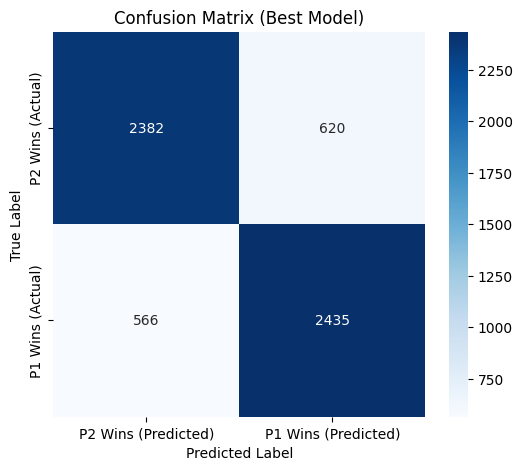

Best tuned model saved successfully to models/tennis_match_predictor_tuned.joblib


In [221]:
# Cell 9.5 (or appropriate new cell): Hyperparameter Tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV

print("Starting Hyperparameter Tuning...")

# Define the parameter grid to search
# These ranges are examples; you can adjust them based on computational resources
param_grid = {
    'n_estimators': [100, 200, 300, 400], # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],     # Number of features to consider when looking for the best split
    'max_depth': [10, 20, 30, None],      # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV
# cv=3 means 3-fold cross-validation
# n_jobs=-1 means use all available CPU cores for faster computation
# verbose=2 will show progress during the search
# scoring='accuracy' (or 'roc_auc' for imbalanced data if applicable)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'), # Keep random_state for reproducibility
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy' # Or 'roc_auc' for better evaluation if classes are imbalanced
)

# Fit GridSearchCV to your training data
# This step can take a while depending on the grid size and your data.
grid_search.fit(X_train, y_train)

print("\nHyperparameter Tuning Complete.")
print("\nBest Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("\nBest Cross-validation Accuracy (using these parameters):")
print(grid_search.best_score_)

# Use the best estimator found by GridSearchCV for final evaluation
best_clf = grid_search.best_estimator_

# Evaluate the best model on the test set
print("\nEvaluating the best model on the test set:")
y_pred_best = best_clf.predict(X_test)
y_proba_best = best_clf.predict_proba(X_test)[:, 1] # Probabilities for the '1' class (P1 wins)

print("Accuracy on Test Set (Best Model):", accuracy_score(y_test, y_pred_best))
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

# You can also re-plot the confusion matrix with the best model's predictions
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['P2 Wins (Predicted)', 'P1 Wins (Predicted)'],
            yticklabels=['P2 Wins (Actual)', 'P1 Wins (Actual)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# After finding the best parameters and evaluating, you'll want to save this best model
# This replaces your previous Cell 11 for saving the model
import joblib
import os

models_dir = 'models' # Or 'notebooks/models' depending on your save location setup
os.makedirs(models_dir, exist_ok=True)
model_filename = os.path.join(models_dir, 'tennis_match_predictor_tuned.joblib') # New name to differentiate

joblib.dump(best_clf, model_filename)
print(f"Best tuned model saved successfully to {model_filename}")

Accuracy: 0.808095952023988

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3002
           1       0.81      0.81      0.81      3001

    accuracy                           0.81      6003
   macro avg       0.81      0.81      0.81      6003
weighted avg       0.81      0.81      0.81      6003



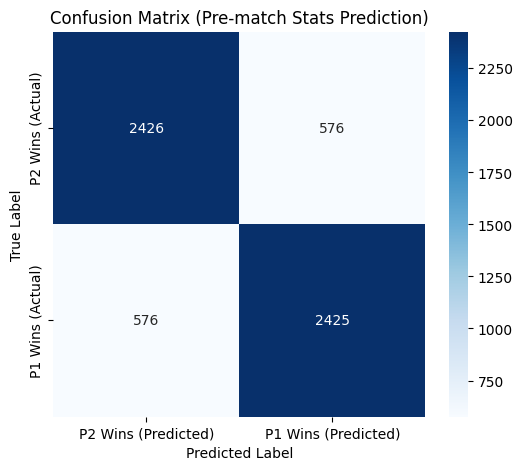

In [222]:
# Cell 9: Evaluate Model Performance

# Ensure X_test is not empty before predicting
if len(X_test) == 0:
    print("Error: Test set is empty. Cannot perform predictions.")
else:
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] # Probabilities for the '1' class (P1 wins)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['P2 Wins (Predicted)', 'P1 Wins (Predicted)'],
                yticklabels=['P2 Wins (Actual)', 'P1 Wins (Actual)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Pre-match Stats Prediction)')
    plt.show()


Feature Importances:
rank_points_diff                                         0.152252
rank_diff                                                0.135138
avg_win_pct_on_surface_diff_last10                       0.094575
avg_win_pct_diff_last10                                  0.073379
avg_total_pts_won_on_serve_pct_diff                      0.051840
height_diff                                              0.045001
age_diff                                                 0.044847
avg_break_pct_on_surface_diff_last10                     0.038590
avg_1st_serve_win_pct_diff                               0.037591
avg_total_pts_won_on_serve_pct_on_surface_diff_last10    0.035596
avg_2nd_serve_win_pct_diff                               0.033563
avg_1st_serve_in_pct_diff                                0.032893
avg_1st_serve_in_pct_on_surface_diff_last10              0.031763
h2h_matches_total                                        0.031076
avg_1st_serve_win_pct_on_surface_diff_last10          

/var/folders/lb/06xxjtz95sqgb8nkwb1ckhgr0000gn/T/ipykernel_10746/1292838021.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


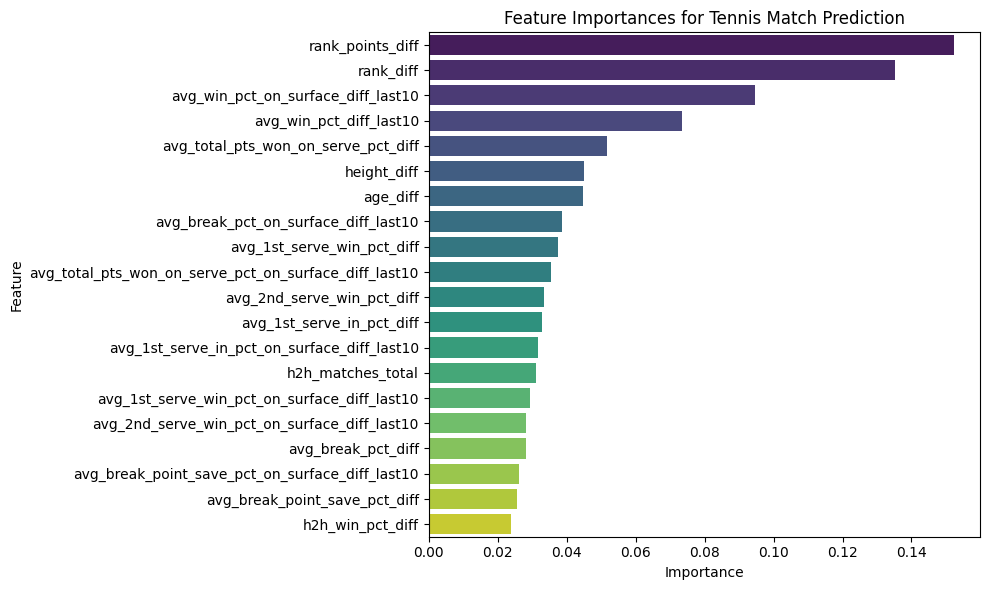

In [223]:
# Cell 10: Analyze Feature Importance (Optional)

# Ensure X has columns for feature importance
if not X.empty:
    feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

    print("\nFeature Importances:")
    print(feature_importances)

    # Optional: Visualize Feature Importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
    plt.title('Feature Importances for Tennis Match Prediction')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot calculate feature importances: X is empty.")


In [224]:
# Cell 11: Save the Trained Model

import joblib
import os

# Define the directory where models will be saved (as shown in your folder structure)
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True) # Create the directory if it doesn't exist

# Define the path to save the model
model_filename = os.path.join(models_dir, 'tennis_match_predictor.joblib')

# Save the model
joblib.dump(clf, model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to models/tennis_match_predictor.joblib
